In [161]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models._utils import IntermediateLayerGetter
from models.modeling.deeplab import *
from PIL import Image
from skimage.transform import resize
from models.model import JointModel
from dataloader.vocabulary import Vocabulary
import cv2

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

In [163]:
class Args:
    lr = 3e-4
    batch_size = 64
    num_workers = 4
    image_encoder = "deeplabv3_plus"
    num_layers = 1
    num_encoder_layers = 1
    dropout = 0.25
    skip_conn = False
    model_path = "/scratch/anant.garg/55.pth"
    dataroot = "/scratch/anant.garg/Talk2Car-RefSeg"
    glove_path = "/scratch/anant.garg/glove"
    vocabulary_path="/home/anant.garg/Documents/iros_24/code/GLC/dataloader/vocabulary.txt"
    dataset = "talk2car"
    task = "talk2car"
    split = "val"
    max_len = 40 
    image_dim = 448
    mask_dim = 448
    mask_thresh = 0.3
    area_thresh = 0.4
    topk = 10
    metric = "pointing_game"

args = Args()

In [164]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()
print(f'{device} being used with {n_gpu} GPUs!!')

cuda being used with 2 GPUs!!


In [165]:
### Creating Vocabulary
vocabulary = Vocabulary(args.vocabulary_path, args.glove_path, args.max_len)

In [166]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
resize = transforms.Resize((args.image_dim, args.image_dim))

In [167]:
transform = transforms.Compose([resize, to_tensor, normalize])

In [168]:
return_layers = {"layer2": "layer2", "layer3": "layer3", "layer4": "layer4"}

# model = DeepLab(num_classes=21, backbone="resnet", output_stride=16)
# model.load_state_dict(torch.load("./models/deeplab-resnet.pth.tar")["state_dict"])

# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# model.load_state_dict(torch.load("/home/t1/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth"))

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.load_state_dict(torch.load("/home/anant.garg/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth"))

image_encoder = IntermediateLayerGetter(model.backbone, return_layers)

for param in image_encoder.parameters():
    param.requires_grad_(False)
    
in_channels = 2048
out_channels = 512
stride = 2

joint_model = JointModel(
    in_channels=in_channels,
    out_channels=out_channels,
    stride=stride,
    num_layers=args.num_layers,
    num_encoder_layers=args.num_encoder_layers,
    dropout=args.dropout,
    skip_conn=args.skip_conn,
    mask_dim=args.mask_dim,
)

# if n_gpu > 1:
#     image_encoder = nn.DataParallel(image_encoder)
#     joint_model = nn.DataParallel(joint_model)  ## toggle this comment if you get key error

state_dict = torch.load(args.model_path)
if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
joint_model.load_state_dict(state_dict) 


Using cache found in /home/anant.garg/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [169]:
joint_model.to(device)
image_encoder.to(device)

image_encoder.eval();
joint_model.eval();

In [170]:
img_path = "/scratch/anant.garg/Talk2Car-RefSeg/imgs/img_train_58.jpg"
# img_path = "/scratch/anant.garg/navbev/carla/4/front_camera/000039.png"
# img_path = "/home/t1/flipped_1.png"
# command = input("Input Command: ")
command = "Take the left turn"
# command = "park near the car on the left side"

In [171]:
# input_image = np.load('/home/t1/gg.npy')
# input_image[:,:,]

# gg = np.array(input_image)
# gg[:,:,0] = input_image[:,:,2]
# gg[:,:,2] = input_image[:,:,0]
# input_image = np.array(gg)

# input_image = np.flip(input_image, axis=1)

In [172]:
# input_image = np.load('/home/t1/gg.npy')
# input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
# input_image = Image.fromarray(input_image)

# input_image = input_image.transpose(PIL.Image.FLIP_LEFT_RIGHT)

input_image = Image.open(img_path)

print(np.array(input_image).shape)

resized_image = np.array(input_image.resize((448, 448)))

print(resized_image.shape)

# input_image = np.array(input_image)
# input_image = input_image[:,:,:3]
# input_image = Image.fromarray(input_image)


# print(input_image.shape)

image = transform(input_image)

phrase, phrase_mask = vocabulary.tokenize(command)

(900, 1600, 3)
(448, 448, 3)


In [173]:
### Prepare for Model
image = image.cuda(non_blocking=True).unsqueeze(0)
image_mask = torch.ones(1, 14 * 14, dtype=torch.int64).cuda(non_blocking=True)

phrase = phrase.unsqueeze(0).cuda(non_blocking=True)
phrase_mask = phrase_mask.unsqueeze(0).cuda(non_blocking=True)

In [174]:
### Input to Model

with torch.no_grad():
    image = image_encoder(image) 
    
output_mask, goal_2d = joint_model(image, phrase, image_mask, phrase_mask)

print(joint_model.fused_feature.shape)

# # goal_2d[0] /= (448 / 1600)
# # goal_2d[1] /= (448 / 900)

print(goal_2d)

Fused features shape:  torch.Size([1, 1536, 14, 14])
torch.Size([1, 1536, 14, 14])
tensor([[-1.5223, -0.5166]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [175]:
temp_goal=goal_2d.clone()

In [365]:
output_mask = output_mask.detach().cpu().squeeze()
goal_2d = temp.detach().cpu().numpy()
#goal_2d = temp.numpy()
print(goal_2d)
print("Output Goal:", goal_2d)
goal_2d[0][0] = int(goal_2d[0][0] * 104.50883928 + 212.26290574)
goal_2d[0][1] = int(goal_2d[0][1] * 57.59293929 + 305.78739969)
print("Transformed Goal: ", goal_2d)
gx = goal_2d[0][0] * 1600 / 448
gy = goal_2d[0][1] * 900 / 448
print("Goal in original space: ", gx, gy)

[[-1.5222895 -0.5166386]]
Output Goal: [[-1.5222895 -0.5166386]]
Transformed Goal:  [[ 53. 276.]]
Goal in original space:  189.28571428571428 554.4642857142857


In [582]:
def project_pixel_to_ground_plane(u, v, camera_matrix, ground_normal, ground_point, extrinsics_cam_to_world):
    
    pixel_coords = np.array([u, v, 1.0])
    normalized_coords = np.linalg.inv(camera_matrix) @ pixel_coords
    normalized_coords /= normalized_coords[2]
    direction_vector_camera = normalized_coords/np.linalg.norm(normalized_coords)
    #direction_vector_camera = np.array([normalized_coords[0], normalized_coords[1], -1.0])

    rotation_matrix = extrinsics_cam_to_world[0:3,0:3]
    camera_position = extrinsics_cam_to_world[0:3,3]
    #rotation_matrix = np.identity(3)
    direction_vector_world = rotation_matrix@direction_vector_camera
    direction_vector_world = direction_vector_world / np.linalg.norm(direction_vector_world)
    
    #direction_vector_world = extrinsic_rotation @ direction_vector_camera
    #camera_position = -extrinsic_rotation.T @ camera_position  # Camera position in world coordinates
    print(np.dot(ground_normal, (ground_point - camera_position)))
    print(np.dot(ground_normal, direction_vector_world))
    t = np.dot(ground_normal, (ground_point - camera_position)) / np.dot(ground_normal, direction_vector_world)
    print("T value",t)
    print("normalized coors",normalized_coords)
    print("ground_normal",ground_normal)
    print("camera_position",camera_position)
    print("direction_vector_world",direction_vector_world)
    print("direction_vector_camera",direction_vector_camera)
     
    intersection_point = camera_position + t * direction_vector_world

    return intersection_point


In [642]:
"""
front_cam_extrinsics = np.array([[ 1.8063e-02, -7.6936e-03,  9.9981e-01,  1.5633e+00],

           [-9.9977e-01,  1.1219e-02,  1.8149e-02,  1.8701e-02],

           [-1.1356e-02, -9.9991e-01, -7.4892e-03,  1.5078e+00],

           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

​

front_cam_intrinsics = np.array([[379.9252,   0.0000, 244.8801],

           [  0.0000, 379.9252, 101.4521],

           [  0.0000,   0.0000,   1.0000]])
"""
from scipy.spatial.transform import Rotation as R

#[[1260.8474446004698, 0.0, 807.968244525554], [0.0, 1260.8474446004698, 495.3344268742088], [0.0, 0.0, 1.0]]
#'translation':[1.70079118954, 0.0159456324149, 1.51095763913], 'rotation': [0.4998015430569128, -0.5030316162024876, 0.4997798114386805, -0.49737083824542755], 'camera_intrinsic': [[1266.417203046554, 0.0, 816.2670197447984], [0.0, 1266.417203046554, 491.50706579294757], [0.0, 0.0, 1.0]]
u = 900
v = 450

focal_length_x=1266.8474446004698
focal_length_y=1266.8474446004698
principal_point_x=816
principal_point_y=235
camera_matrix = np.array([[focal_length_x, 0, principal_point_x],
                         [0, focal_length_y, principal_point_y],
                         [0, 0, 1]])
extrinsics=np.eye(4)
rotation=R.from_quat([0.4998015430569128, -0.5030316162024876, 0.4997798114386805, -0.49737083824542755]).as_matrix()
translation=[1.70079118954, 0.0159456324149, 1.51095763913]

extrinsics[0:3,0:3]=rotation
extrinsics[0:3,3]=translation
print(extrinsics)


ground_normal = np.array([0, 0, 1])  # Z-axis as the normal direction
ground_point = np.array([0, 0, 0])   # A point on the ground plane


# Project the pixel onto the ground plane
intersection_point = project_pixel_to_ground_plane(u, v, camera_matrix, ground_normal, ground_point,extrinsics)
print("gx: ",gx, "gy:",gy)
print("Intersection Point on Ground Plane:", intersection_point)



[[-5.64133364e-03 -5.68014846e-03  9.99967955e-01  1.70079119e+00]
 [-9.99983763e-01  8.37115272e-04 -5.63666773e-03  1.59456324e-02]
 [-8.05071338e-04 -9.99983517e-01 -5.68477868e-03  1.51095764e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
-1.51095763913
-0.17260620855418457
T value 8.753784998734154
normalized coors [0.06630633 0.16971262 1.        ]
ground_normal [0 0 1]
camera_position [1.70079119 0.01594563 1.51095764]
direction_vector_world [ 0.98245485 -0.07063689 -0.17260621]
direction_vector_camera [0.06523235 0.16696374 0.98380275]
gx:  189.28571428571428 gy: 554.4642857142857
Intersection Point on Ground Plane: [ 1.03009897e+01 -6.02394500e-01  2.22044605e-16]


In [638]:

def project_3d_point_to_pixel( camera_matrix, extrinsic,X, Y, Z):
    
    point_homogeneous = np.array([X, Y, Z, 1.0])
    print(point_homogeneous)
    camera_coordinates = extrinsic @ point_homogeneous.T
    print("coors",camera_coordinates)


    normalized_coords = camera_matrix @ camera_coordinates[0:3]
    normalized_coords /= normalized_coords[2]

    # Convert normalized coordinates to pixel coordinates
    pixel_coords = normalized_coords[:2]

    return pixel_coords

In [595]:
print(camera_matrix)
print(front_cam_extrinsics)
project_3d_point_to_pixel(camera_matrix,np.linalg.inv(extrinsics),intersection_point[0],intersection_point[1],intersection_point[2])

[[800.8474446   0.        807.       ]
 [  0.        800.8474446 495.       ]
 [  0.          0.          1.       ]]
[[ 0.018063  -0.0076936  0.99981    1.5633   ]
 [-0.99977    0.011219   0.018149   0.018701 ]
 [-0.011356  -0.99991   -0.0074892  1.5078   ]
 [ 0.         0.         0.         1.       ]]
[72.77364054 50.1828829   0.          1.        ]
coors [-50.56585196   1.14922391  70.79638693   1.        ]


array([235., 508.])

In [589]:
# threshold = float(input('threshold for mask: '))
threshold = float(0.2)
assert 0<= threshold < 1 

In [460]:
output_mask

tensor([[0.0046, 0.0025, 0.0014,  ..., 0.0025, 0.0047, 0.0088],
        [0.0023, 0.0012, 0.0006,  ..., 0.0011, 0.0023, 0.0045],
        [0.0012, 0.0006, 0.0003,  ..., 0.0005, 0.0011, 0.0023],
        ...,
        [0.0029, 0.0014, 0.0007,  ..., 0.0011, 0.0023, 0.0048],
        [0.0045, 0.0025, 0.0013,  ..., 0.0020, 0.0040, 0.0079],
        [0.0072, 0.0042, 0.0024,  ..., 0.0037, 0.0070, 0.0130]])

In [123]:
im_seg = np.array(resized_image)[:] / 2

predicts = (output_mask > threshold).numpy()


im_seg[:, :, 0] += predicts.astype('uint8') * 100
im_seg = im_seg.astype('uint8')

cv2.circle(im_seg, (int(goal_2d[0][0]), int(goal_2d[0][1])), 5, [0, 255, 0], thickness=-1)

array([[[24, 24, 23],
        [27, 27, 27],
        [31, 31, 30],
        ...,
        [22, 25, 23],
        [24, 26, 24],
        [24, 26, 24]],

       [[23, 23, 22],
        [25, 25, 24],
        [27, 27, 26],
        ...,
        [21, 24, 22],
        [24, 26, 24],
        [23, 25, 23]],

       [[24, 24, 22],
        [24, 24, 24],
        [26, 26, 25],
        ...,
        [20, 22, 20],
        [22, 24, 22],
        [22, 25, 23]],

       ...,

       [[44, 45, 43],
        [49, 49, 47],
        [49, 49, 47],
        ...,
        [55, 57, 57],
        [55, 57, 58],
        [56, 58, 59]],

       [[44, 44, 43],
        [50, 50, 49],
        [49, 49, 49],
        ...,
        [56, 58, 57],
        [56, 58, 58],
        [55, 57, 57]],

       [[43, 43, 43],
        [50, 50, 50],
        [49, 49, 49],
        ...,
        [56, 58, 57],
        [56, 58, 58],
        [55, 57, 57]]], dtype=uint8)

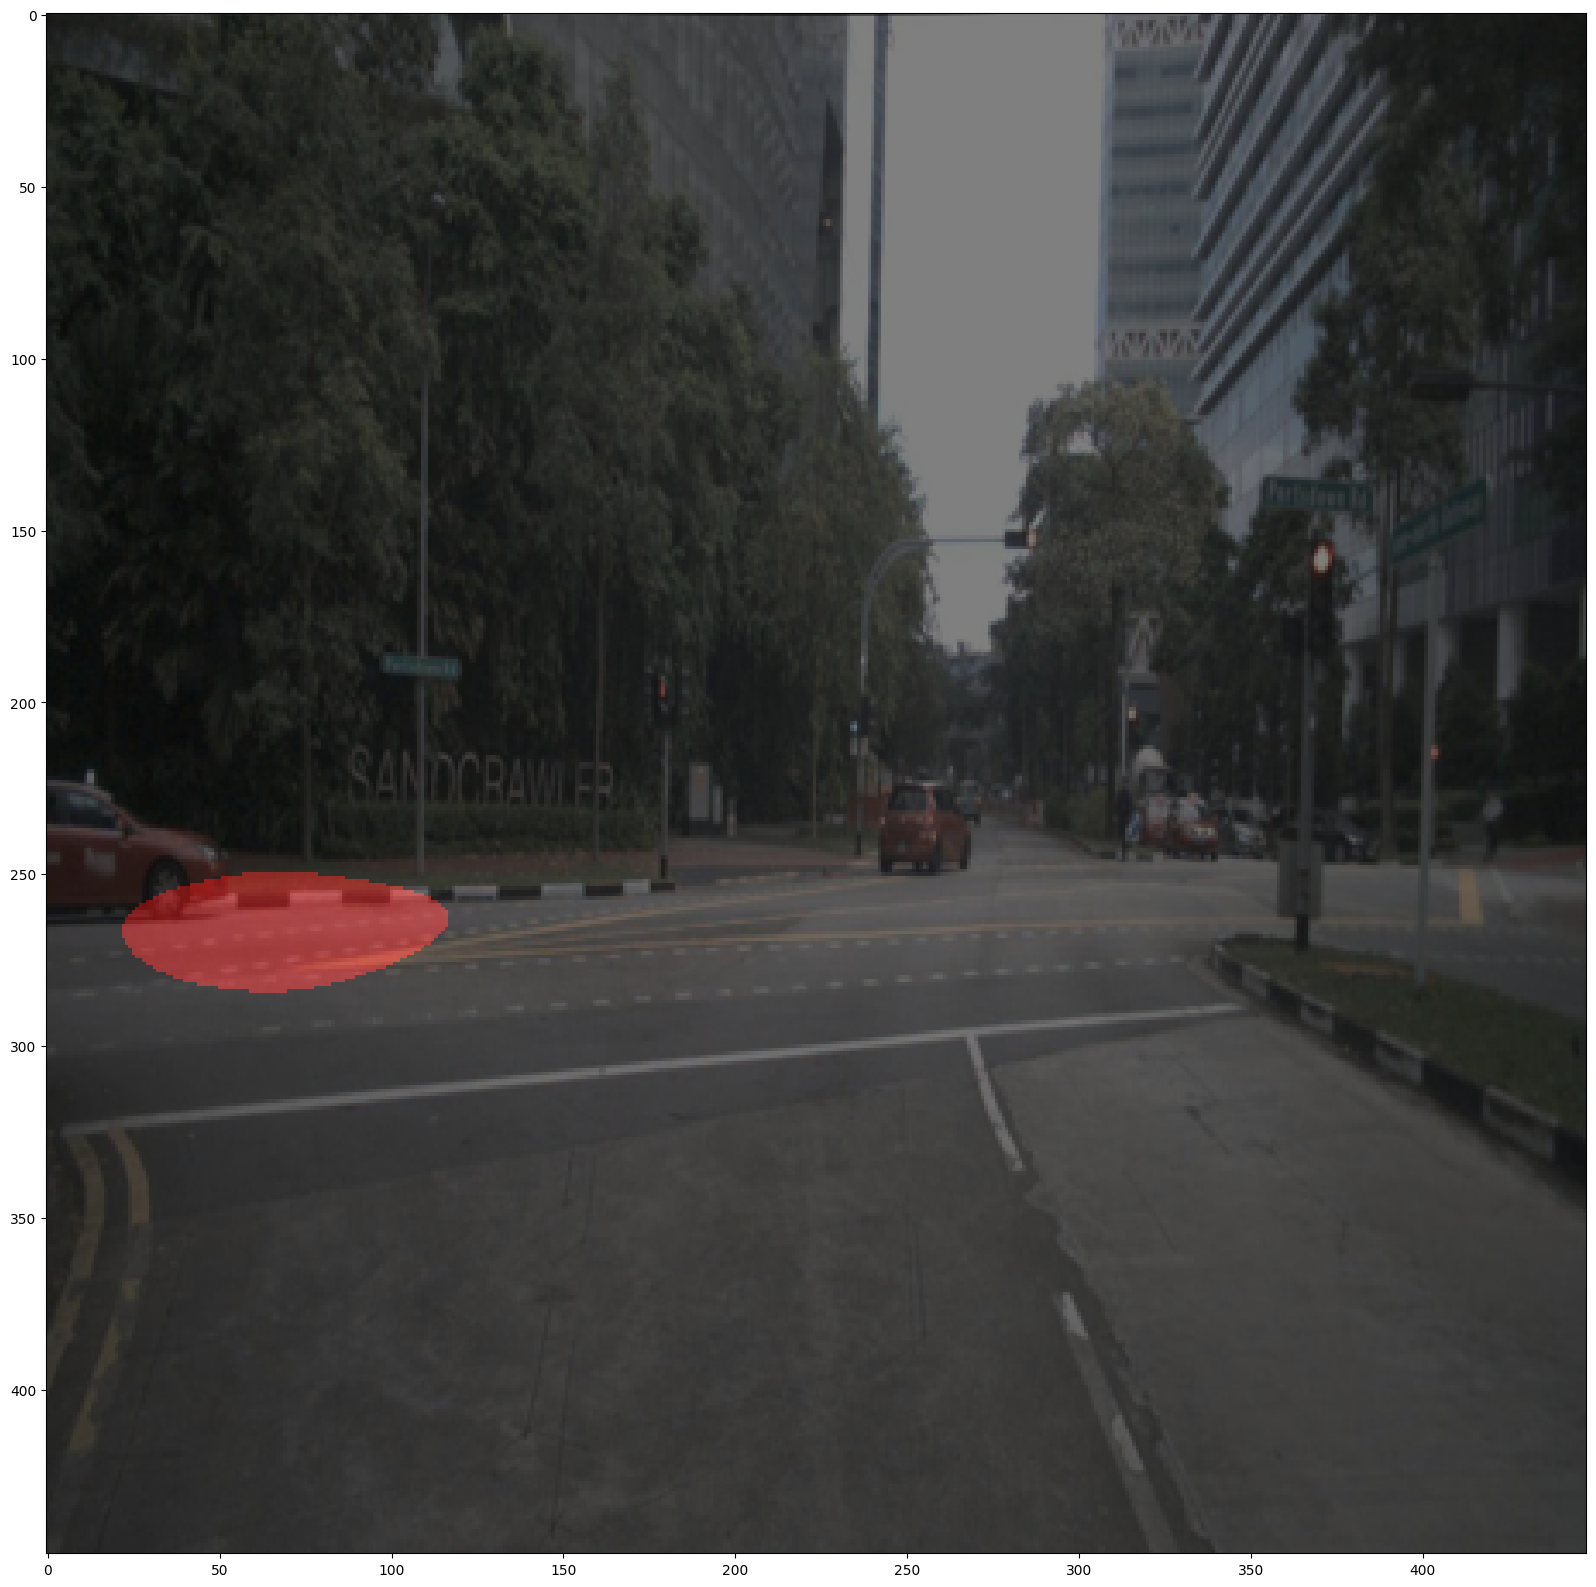

In [124]:
## Display the Output

figure = plt.figure(figsize=(20, 20))
plt.imshow(im_seg)

In [125]:
# 1. Park where the man is pointing
# 2. Park near the car in front
# 3. Take the right turn
# 4. Park near the bus
# 5. Park near the bus on right